In [1]:
import pandas as pd
import config
import pickle
import matplotlib.pyplot as plt
import numpy as np

output_path = config.CONFIG_OUTPUT_PATH["final_outputs"]


In [2]:
# define paths
metrics_darts = config.CONFIG_OUTPUT_PATH["darts"] / "darts_metrics.csv"
metrics_path_tl_itransformer = config.CONFIG_OUTPUT_PATH["itransformer"] / "itransformer_results_transfer_learning_revin.csv"
metrics_path_baseline_itransformer = config.CONFIG_OUTPUT_PATH["itransformer"] / "itransformer_results_baseline.csv"
metrics_timegpt = config.CONFIG_OUTPUT_PATH["TimeGPT"] / "timegpt_results.csv"


# read csv
metrics_darts = pd.read_csv(metrics_darts)
metrics_tl_itransformer = pd.read_csv(metrics_path_tl_itransformer)
metrics_baseline_itransformer = pd.read_csv(metrics_path_baseline_itransformer)
metrics_timegpt = pd.read_csv(metrics_timegpt, index_col=[0])

# split "setup" into source/target column
metrics_tl_itransformer[['Source', 'Target']] = metrics_tl_itransformer['Setup'].str.split('_to_', expand=True)
metrics_tl_itransformer = metrics_tl_itransformer.drop(columns=['Setup'])
metrics_darts[['Source', 'Target']] = metrics_darts['Setup'].str.split('_to_', expand=True)
metrics_darts = metrics_darts.drop(columns=['Setup'])

# drop nan
metrics_baseline_itransformer = metrics_baseline_itransformer.dropna()
metrics_tl_itransformer = metrics_tl_itransformer.dropna()

# split darts df into baseline/tl
metrics_darts_baseline = metrics_darts[metrics_darts['Learning_scenario'].isin(['full_training', 'four_weeks_training'])]
metrics_darts_baseline = metrics_darts_baseline.drop(columns=["Source"])
metrics_darts_baseline = metrics_darts_baseline.drop_duplicates(subset=['Target', 'Learning_scenario', 'Metric'])
metrics_darts_tl = metrics_darts[metrics_darts['Learning_scenario'].isin(['Zero-Shot', 'four_weeks_tl', 'full_tl'])]

# sort baseline dataframes the same way and merge
baseline_index = ["Target", "Learning_scenario", "Metric"]
metrics_baseline_itransformer = metrics_baseline_itransformer.set_index(baseline_index)
metrics_darts_baseline = metrics_darts_baseline.set_index(baseline_index)

metrics_darts_baseline = metrics_darts_baseline.sort_index(level=baseline_index)
metrics_baseline_itransformer = metrics_baseline_itransformer.sort_index(level=baseline_index)

#metrics_baseline_itransformer
metrics_darts_baseline["iTransformer"] = metrics_baseline_itransformer["iTransformer"]
baseline_metrics_dl = metrics_darts_baseline

# append itransformer metrics to darts df
tl_index = ["Target", "Source", "Learning_scenario", "Metric"]
metrics_darts_tl = metrics_darts_tl.set_index(tl_index)
metrics_tl_itransformer = metrics_tl_itransformer.set_index(tl_index)
metrics_darts_tl["iTransformer"] = metrics_tl_itransformer["iTransformer"]
tl_metrics = metrics_darts_tl
tl_metrics = tl_metrics.sort_index(level=["Target"])

# reshape timegpt results
metrics_timegpt = metrics_timegpt.transpose()
metrics_timegpt = metrics_timegpt.stack()
metrics_timegpt = metrics_timegpt.reset_index()
metrics_timegpt.columns = ['Metric', 'Target', 'TimeGPT']

df = tl_metrics.reset_index()
timegpt_df = metrics_timegpt
zero_shot_df = df[df['Learning_scenario'] == 'Zero-Shot']

# Merge the TimeGPT values with the zero-shot DataFrame on Target and Metric
zero_shot_merged = zero_shot_df.merge(timegpt_df, on=['Target', 'Metric'], how='left')

# Combine the results back into the original DataFrame
tl_metrics = df.merge(zero_shot_merged[['Target', 'Source', 'Learning_scenario', 'Metric', 'TimeGPT']],\
                       on=['Target', 'Source', 'Learning_scenario', 'Metric'], how='left')

baseline_metrics_dl = baseline_metrics_dl.reset_index()
baseline_metrics_dl["Source"] = baseline_metrics_dl["Target"]

# split into target datasets
tmp = pd.concat([tl_metrics, baseline_metrics_dl])

# nbeats is dropped because in many cases it does not manage to learn meaningfull information
Bavaria = tmp[tmp["Target"] == "Bavaria"]
Bavaria = Bavaria.drop(columns=(["Target", "NBEATS"]))
ELD = tmp[tmp["Target"] == "ELD"]
ELD = ELD.drop(columns=(["Target", "NBEATS"]))
GP2 = tmp[tmp["Target"] == "GP2"]
GP2 = GP2.drop(columns=(["Target", "NBEATS"]))

target_dataset_metrics = {"Bavaria": Bavaria,
                        "ELD" : ELD,
                        "GP2" : GP2
            }

# load and reshape arima results
preds_dict = {
"ELD" : config.CONFIG_OUTPUT_PATH["arima"] / 'arima_electricity_predictionsfull.pkl',
"Bavaria" : config.CONFIG_OUTPUT_PATH["arima"] / 'arima_bavaria_predictionsfull.pkl',
"GP2" : config.CONFIG_OUTPUT_PATH["arima"] / 'arima_genome_project_predictionsfull.pkl',
    }

arima_results = pd.DataFrame(index=["MSE", "MAE"])

for key, value in preds_dict.items():
    with open(value, 'rb') as file:
        preds = pickle.load(file)

    mse_preds = [element[0] for element in preds]
    mse = sum(mse_preds) / len(mse_preds)

    mae_preds = [element[2] for element in preds]
    mae = sum(mae_preds) / len(mae_preds)
    arima_results[key] = [mse, mae]


In [3]:
def calc_metrics(dataset, target="Bavaria", source_1="GP2", source_2="ELD"):
    dataset = dataset[dataset["Metric"] == "MSE"]

    dataset = dataset.set_index(["Source", "Learning_scenario", "Metric"])
    dataset.loc[(target, "full_training", "MSE"), "Mean MSE"] = dataset.loc[(target, "full_training", "MSE"), :].mean()
    dataset.loc[(target, "four_weeks_training", "MSE"), "Mean MSE"] = dataset.loc[(target, "four_weeks_training", "MSE"), :].mean()
    dataset.loc[(source_1, "full_tl", "MSE"), "Mean MSE"] = dataset.loc[(source_1, "full_tl", "MSE"), :].mean()
    dataset.loc[(source_2, "full_tl", "MSE"), "Mean MSE"] = dataset.loc[(source_2, "full_tl", "MSE"), :].mean()
    dataset.loc[(source_1, "Zero-Shot", "MSE"), "Mean MSE"] = dataset.loc[(source_1, "Zero-Shot", "MSE"), :].mean()
    dataset.loc[(source_2, "Zero-Shot", "MSE"), "Mean MSE"] = dataset.loc[(source_2, "Zero-Shot", "MSE"), :].mean()
    dataset.loc[(source_1, "four_weeks_tl", "MSE"), "Mean MSE"] = dataset.loc[(source_1, "four_weeks_tl", "MSE"), :].mean()
    dataset.loc[(source_2, "four_weeks_tl", "MSE"), "Mean MSE"] = dataset.loc[(source_2, "four_weeks_tl", "MSE"), :].mean()

    for i in dataset.columns:
        dataset.loc[("Overall mean", "All experiments", "MSE"),i] =  dataset[i].mean()

    return dataset


target_dataset_metrics["Bavaria_mse"] = calc_metrics(target_dataset_metrics["Bavaria"], "Bavaria", "GP2", "ELD")    
target_dataset_metrics["GP2_mse"] = calc_metrics(target_dataset_metrics["GP2"], "GP2", "Bavaria", "ELD")                   
target_dataset_metrics["ELD_mse"] = calc_metrics(target_dataset_metrics["ELD"], "ELD", "GP2", "Bavaria")                                  

/tmp/ipykernel_73453/3136187499.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  dataset.loc[(target, "full_training", "MSE"), "Mean MSE"] = dataset.loc[(target, "full_training", "MSE"), :].mean()
/tmp/ipykernel_73453/3136187499.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  dataset.loc[(target, "four_weeks_training", "MSE"), "Mean MSE"] = dataset.loc[(target, "four_weeks_training", "MSE"), :].mean()
/tmp/ipykernel_73453/3136187499.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  dataset.loc[(source_1, "full_tl", "MSE"), "Mean MSE"] = dataset.loc[(source_1, "full_tl", "MSE"), :].mean()
/tmp/ipykernel_73453/3136187499.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  dataset.loc[(source_2, "full_tl", "MSE"), "Mean MSE"] = dataset.loc[(source_2, "full_tl", "MSE"), :].mean()
/tmp/ipykernel_73453/3136187499.py:9: PerformanceWarning: indexing past lexsort depth may im

In [4]:
arima_results.to_csv(output_path / "arima_results.csv")

for key, value in target_dataset_metrics.items():
    value.to_csv(output_path / f"{key}_target_results.csv")

# Presentation

In [5]:
target_dataset_metrics["ELD_mse"]

NHiTS  Transformer    TSMixer  \
Source       Learning_scenario   Metric                                      
Bavaria      Zero-Shot           MSE     10.242845     9.365124  11.590646   
             four_weeks_tl       MSE      0.427707     0.952589   0.471168   
             full_tl             MSE      0.286422     0.321436   0.224299   
GP2          Zero-Shot           MSE      0.784147     1.243249   1.326016   
             four_weeks_tl       MSE      0.401205     0.465202   0.312831   
             full_tl             MSE      0.288997     0.322184   0.223821   
ELD          four_weeks_training MSE      0.380317     0.407014   0.318748   
             full_training       MSE      0.279225     0.310126   0.235956   
Overall mean All experiments     MSE      1.636358     1.673365   1.837936   

                                         iTransformer   TimeGPT  Mean MSE  
Source       Learning_scenario   Metric                                    
Bavaria      Zero-Shot           MSE         2.191598  0.066775  6.691398  
             four_weeks_tl       MSE         0.316252       NaN  0.541929  
             full_tl             MSE         0.185281       NaN  0.254360  
GP2          Zero-Shot           MSE         0.331429  0.066775  0.750323  
             four_weeks_tl       MSE         0.218327       NaN  0.349392  
             full_tl             MSE         0.179492       NaN  0.253623  
ELD          four_weeks_training MSE         0.251246       NaN  0.339331  
             full_training       MSE         0.177929       NaN  0.250809  
Overall mean All experiments     MSE         0.481444  0.066775  1.178896

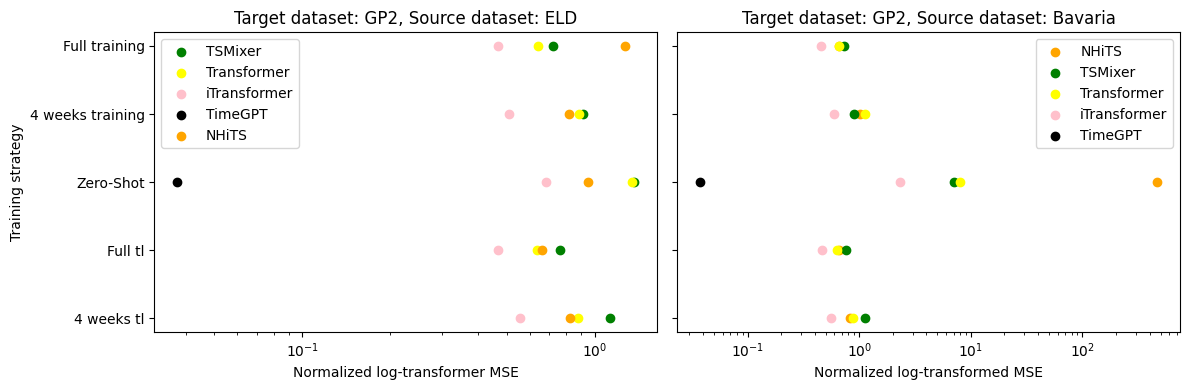

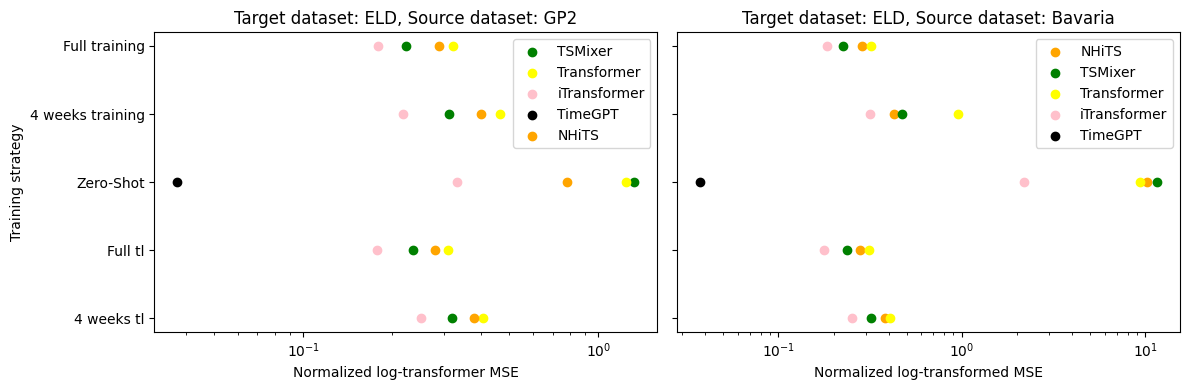

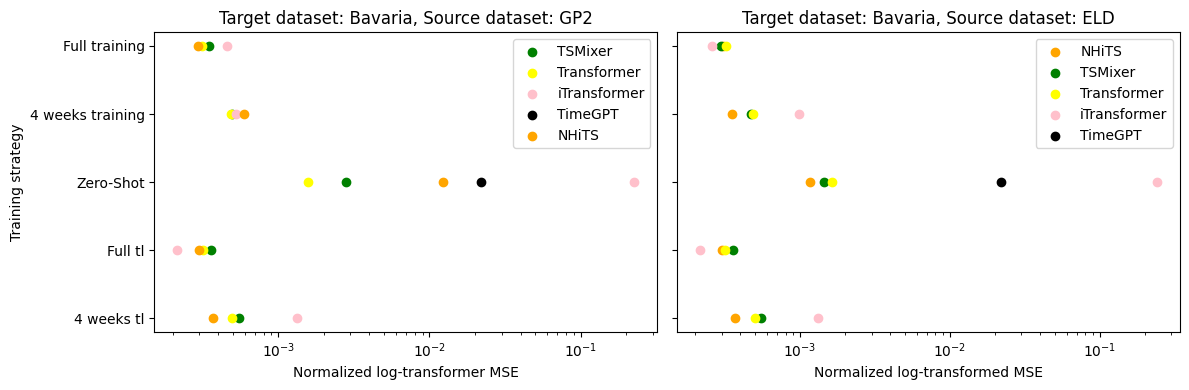

In [6]:
# create 1 scatterplot per target-source combination containing all training-strategies and models

def create_source_dataset_metrics(model, target, source):
    return_dict = {}
    baseline_values = list(target_dataset_metrics[f"{target}_mse"][model][target].values)

    for key in source.keys():
        return_dict[key] =  target_dataset_metrics[f"{target}_mse"][model][key].values
        return_dict[key] = baseline_values + list(return_dict[key])
    return return_dict


def visualize(target_dataset):
    x = ["4 weeks tl", "Full tl", "Zero-Shot", "4 weeks training", "Full training"]
    datasets_dict = {"GP2" : None, "ELD": None, "Bavaria": None}
    source = {key: value for key, value in datasets_dict.items() if key != target_dataset}

    y_nhits = create_source_dataset_metrics("NHiTS", target_dataset, source)
    y_transformer = create_source_dataset_metrics("Transformer", target_dataset, source)
    y_itransformer = create_source_dataset_metrics("iTransformer", target_dataset, source)
    y_tsmixer = create_source_dataset_metrics("TSMixer", target_dataset, source)
    y_timegpt = [np.nan, np.nan] + [target_dataset_metrics[target_dataset]["TimeGPT"].values[0]] + [np.nan, np.nan]

    # Create a figure and axis
    # Plot multiple line
    key_1, key_2 = source.keys()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    ax2.set_xscale('log')
    ax1.set_xscale('log')

    ax1.scatter(y_tsmixer[key_1], x,label="TSMixer", marker='o', color="green")
    ax1.scatter(y_transformer[key_1], x, label="Transformer", marker='o', color="yellow")
    ax1.scatter(y_itransformer[key_1], x, label="iTransformer", marker='o', color="pink")
    ax1.scatter(y_timegpt, x, label="TimeGPT", marker='o', color="black")
    ax1.scatter(y_nhits[key_1], x, label="NHiTS", marker='o', color="orange")


    # Add a title and labels
    ax1.set_title(f'Target dataset: {target_dataset}, Source dataset: {key_1}')
    ax1.set_ylabel('Training strategy')
    ax1.set_xlabel('Normalized log-transformer MSE')

    plt.xscale('log')

    # Add a legend
    ax1.legend()

    # second source dataset
    ax2.scatter(y_nhits[key_2], x, label="NHiTS", marker='o', color="orange")
    ax2.scatter(y_tsmixer[key_2], x,label="TSMixer", marker='o', color="green")
    ax2.scatter(y_transformer[key_2], x, label="Transformer", marker='o', color="yellow")
    ax2.scatter(y_itransformer[key_2], x, label="iTransformer", marker='o', color="pink")
    ax2.scatter(y_timegpt, x, label="TimeGPT", marker='o', color="black")


    # Add a title and labels
    ax2.set_title(f'Target dataset: {target_dataset}, Source dataset: {key_2}')
    #ax2.set_ylabel('Training strategy')
    ax2.set_xlabel('Normalized log-transformed MSE')

    # Add a legend
    ax2.legend()
    plt.tight_layout()
    plt.savefig(output_path / f'target_{target_dataset}.png', format='png')  # Save as PNG file

    plt.show()


visualize("GP2")
visualize("ELD")
visualize("Bavaria")

In [7]:
# calculate jumpstart & asymptotic performance

jumpstart = four_weeks_train / ((four_weeks_tl + zero_shot) / 2)

asymptotic_perf = full_train / ((four_weeks_tl + full_tl) / 2) 

NameError: name 'four_weeks_train' is not defined

In [12]:
# jumpstart
def add_list_element_div_2(list_1, list_2):
    assert len(list_1) == len(list_2), "List must be same length"
    output = [(a + b)/2 for a, b in zip(list_1, list_2)]
    return output

def divide_two_lists(list_1, list_2):
    assert len(list_1) == len(list_2), "List must be same length"
    output = [a / b for a, b in zip(list_1, list_2)]
    return output

def calc_tl_metrics(target):
    models = ["NHiTS", "Transformer", "iTransformer", "TSMixer"]
    datasets_dict = {"GP2" : None, "ELD": None, "Bavaria": None}
    source = {key: value for key, value in datasets_dict.items() if key != target}
    source_1, source_2 = source.keys()

    # define target metrics
    four_weeks_train = list(target_dataset_metrics[f"{target}_mse"][models].loc[(target, "four_weeks_training")].values[0])
    full_train = list(target_dataset_metrics[f"{target}_mse"][models].loc[(target, "full_training")].values[0])

    # define source metrics
    four_weeks_tl_1 = list(target_dataset_metrics[f"{target}_mse"][models].loc[(source_1, "four_weeks_tl")].values[0])
    zero_shot_1 = list(target_dataset_metrics[f"{target}_mse"][models].loc[(source_1, "Zero-Shot")].values[0])
    full_tl_1 = list(target_dataset_metrics[f"{target}_mse"][models].loc[(source_1, "full_tl")].values[0])

    four_weeks_tl_2 = list(target_dataset_metrics[f"{target}_mse"][models].loc[(source_2, "four_weeks_tl")].values[0])
    zero_shot_2 = list(target_dataset_metrics[f"{target}_mse"][models].loc[(source_2, "Zero-Shot")].values[0])
    full_tl_2 = list(target_dataset_metrics[f"{target}_mse"][models].loc[(source_2, "full_tl")].values[0])

    four_weeks_tl = add_list_element_div_2(four_weeks_tl_1, four_weeks_tl_2)
    zero_shot = add_list_element_div_2(zero_shot_1, zero_shot_2)
    full_tl = add_list_element_div_2(full_tl_1, full_tl_2)


    #short_target_metrics = add_list_element_div_2(four_weeks_train, zero_shot)
    jumpstart = divide_two_lists(four_weeks_train,four_weeks_tl )
    jumpstart_1 = divide_two_lists(four_weeks_train, four_weeks_tl_1)
    jumpstart_2 = divide_two_lists(four_weeks_train, four_weeks_tl_2)

    jumpstart_zero_shot = divide_two_lists(four_weeks_train,zero_shot )


    #long_target_metrics = add_list_element_div_2(four_weeks_tl, full_tl)
    asymptotic_perf = divide_two_lists(full_train, full_tl)#long_target_metrics)
    asymptotic_perf_1 = divide_two_lists(full_train, full_tl_1)#long_target_metrics)
    asymptotic_perf_2 = divide_two_lists(full_train, full_tl_2)#long_target_metrics)

    negative_series = pd.Series([-1,-1,-1,-1])

    df = pd.DataFrame()
    df["Jumpstart fine_tune combined"] = ((negative_series) + jumpstart) * 100
    df["Jumpstart zero-shot"] = ((negative_series) + jumpstart_zero_shot) *100
    df[f"Jumpstart fine tune {source_1}"] = ((negative_series) + jumpstart_1) * 100
    df[f"Jumpstart fine tune {source_2}"] = ((negative_series) + jumpstart_2) * 100

    df["Asymptotic combined"] = ((negative_series) + asymptotic_perf) *100
    df[f"Asymptotic {source_1}"] = ((negative_series) + asymptotic_perf_1) *100
    df[f"Asymptotic {source_2}"] = ((negative_series) + asymptotic_perf_2) *100

    df.index = models
   # df.loc["Mean"] = df["Jumpstart improvement [%]"].mean(), df["Asymptotic improvement [%]"].mean()
    return df

eld = calc_tl_metrics("ELD")
bavaria = calc_tl_metrics("Bavaria")
gp2 = calc_tl_metrics("GP2")

eld.to_csv(output_path / "ELD_jumpstart_asymp_perf.csv")
bavaria.to_csv(output_path / "Bavaria_jumpstart_asypm_perf.csv")
gp2.to_csv(output_path / "GP2_jumpstart_asymp_perf.to_csv")
eld

/tmp/ipykernel_73453/1659671028.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  four_weeks_train = list(target_dataset_metrics[f"{target}_mse"][models].loc[(target, "four_weeks_training")].values[0])
/tmp/ipykernel_73453/1659671028.py:20: PerformanceWarning: indexing past lexsort depth may impact performance.
  full_train = list(target_dataset_metrics[f"{target}_mse"][models].loc[(target, "full_training")].values[0])
/tmp/ipykernel_73453/1659671028.py:23: PerformanceWarning: indexing past lexsort depth may impact performance.
  four_weeks_tl_1 = list(target_dataset_metrics[f"{target}_mse"][models].loc[(source_1, "four_weeks_tl")].values[0])
/tmp/ipykernel_73453/1659671028.py:24: PerformanceWarning: indexing past lexsort depth may impact performance.
  zero_shot_1 = list(target_dataset_metrics[f"{target}_mse"][models].loc[(source_1, "Zero-Shot")].values[0])
/tmp/ipykernel_73453/1659671028.py:25: PerformanceWarning: indexing past lexsort depth may impact 

,Jumpstart fine_tune combined,Jumpstart zero-shot,Jumpstart fine tune GP2,Jumpstart fine tune Bavaria,Asymptotic combined,Asymptotic GP2,Asymptotic Bavaria
NHiTS,-8.237143,-93.102071,-5.206419,-11.080075,-2.949082,-3.381338,-2.512941
Transformer,-42.584828,-92.326560,-12.508265,-57.272895,-3.630670,-3.742438,-3.518643
iTransformer,-6.002182,-80.083732,15.077911,-20.555001,-2.443695,-0.870623,-3.967620
TSMixer,-18.686733,-95.064548,1.891254,-32.349456,5.309187,5.421658,5.196957


In [13]:
column_names = ["Jumpstart fine tuned combined", "Jumpstart zero-shot", "Asymptotic performance"]
columns = ["Jumpstart fine_tune combined",	"Jumpstart zero-shot",	"Asymptotic combined"]
eld =  eld[columns]
eld.columns = column_names
bavaria = bavaria[columns]
bavaria.columns=column_names
gp2 = gp2[columns]
gp2.columns = column_names
all = eld + bavaria + gp2
all

,Jumpstart fine tuned combined,Jumpstart zero-shot,Asymptotic performance
NHiTS,-40.338012,-287.245494,-34.574861
Transformer,-53.714721,-242.479042,-5.293262
iTransformer,70.907080,-242.887866,-41.594089
TSMixer,19.022641,-242.368311,20.391503
